In [204]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# TODO try to avoid the need of the sys.path.apppend call
import sys
sys.path.append("..")
from cwc.models.density_estimators import MyMultivariateNormal
from cwc.models.background_check import BackgroundCheck
from cwc.models.density_estimators import MyGMM

plt.rcParams['figure.figsize'] = (12,4)

In [223]:
def draw_in_row(fruits, sizes):
    from PIL import Image
    images = map(Image.open, ['./images/'+fruit+'.jpg' for fruit in fruits])
    widths, heights = zip(*(i.size for i in images))

    unit_width = 200
    drawing_sizes = np.array(sizes*unit_width, dtype=int)
    total_width = drawing_sizes.sum()+unit_width
    max_height = drawing_sizes.max()

    new_im = Image.new('RGB', (total_width, max_height),color=(255,255,255,0))

    drawn_ball = False
    x_offset = 0
    for im, drawing_size in zip(images, drawing_sizes):
        if not drawn_ball and drawing_size >= unit_width:
            im = Image.open('./images/tennis_ball.jpg')
            im = im.resize([unit_width, unit_width])
            drawn_ball = True
        im = im.resize([drawing_size,drawing_size])
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]

    ax = plt.figure(figsize=(7,5), dpi=80)
    plt.imshow(new_im)
    plt.axis('off')

# Background check

Imagine a simple classification example between lemons and oranges where the only feature is the relative size to a tennis ball. We are denoting to be a small fruit if it is smaller than a tennis ball and big otherwise.

We can define the next notation for the different fruits and sizes:

- $F$: Fruit
- $L$: Lemon
- $O$: Orange
- $S$: Small
- $B$: Big

Then, we can colect some lemons and oranges and try to estimate what are the different probabilities. In order to get these examples all the fruits that are not lemons or oranges are discarded as we do not need to classify between other fruits. Then we get a cleaned sample containing only the desired lemons and orange with their respective relative size to a tennis ball.

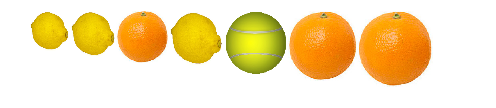

In [224]:
size_of_tennis_ball = 1
fruits = np.array(['lemon', 'lemon', 'orange', 'lemon', 'lemon', 'orange', 'orange'])
sizes  = np.array([0.7, 0.8, 0.9, 0.95, 1.1, 1.2, 1.3])

draw_in_row(fruits, sizes)

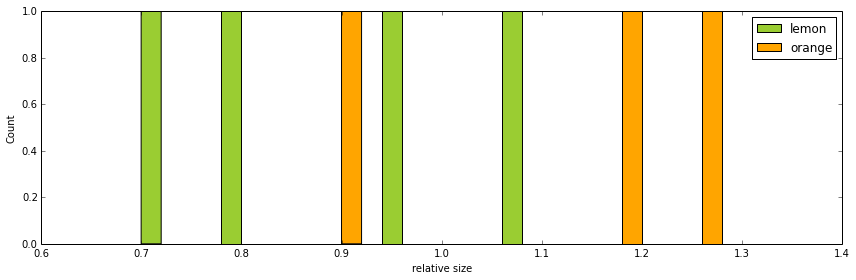

In [225]:
plt.hist(sizes[fruits == 'lemon'], color='yellowgreen', label='lemon', width=0.02)
plt.hist(sizes[fruits == 'orange'], color='orange', label='orange', width=0.02)
plt.legend()
plt.xlabel('relative size')
plt.ylabel('Count')

With this small set of examples we can start estimating the different probabilities of being a specific fruit or size. Then, we will denote the different probabilities as:

- $P(L)$ = Prior probability of being a Lemon

$$ P(L) \sim \frac{|L|}{|F|} \sim \frac{|L|}{|L|+|O|}$$
- $P(S)$ = Prior probability of being Small (smaller than a tennis ball)

$$ P(S) \sim \frac{|S|}{|F|} \sim \frac{|S|}{|S|+|B|}$$
- $P(S|L)$ = Probability of being small given that we know that it is a lemon
$$ P(S|L) \sim \frac{|L| \bigcap |S|}{|L|}$$

Then we can compute these estimates with our small sample:

In [226]:
P_L = np.mean(fruits == 'lemon')
P_S = np.mean(sizes < size_of_tennis_ball)
P_S_g_L = np.logical_and(fruits == 'lemon', sizes < size_of_tennis_ball).sum()/(fruits == 'lemon').sum()

print('P(L) = {0:1.2f}%'.format(P_L))
print('P(S) = {0:1.2f}%'.format(P_S))
print('P(S|L) = {0:1.2f}%'.format(P_S_g_L))

P(L) = 0.57%
P(S) = 0.57%
P(S|L) = 0.75%


Now that we have this information we can try to estimate what is the probability of getting a lemon or an orange given a specific size.

Bayes theorem states that:

$$
    P(L|S) = \frac{P(S|L)*P(L)}{P(S)} = \frac{P(S|L)*P(L)}{P(S|L)*P(L) + P(S|\bar L)*P(\bar L)}
$$

However, because it is not possible to estimate $P(S)$ for all the possible objects, it is assumed that we can get an estimate in our given sample with lemons and apples. In our case, we are assuming that all the objects that are not lemons are apples. Then Bayes' theorem can be written as:

$$
    P(L|S) = \frac{P(S|L)*P(L)}{P(S)} = \frac{P(S|L)*P(L)}{P(S|L)*P(L) + P(S|A)*P(A)}
$$

Where $P(A)$ is the probability of being an apple and $P(S|A)$ is the probability of being small given that it is an apple.

$$
    P(L|S) = \frac{P(S|L)*P(L)}{P(S)} = \frac{P(S|L)*P(L)}{P(S|L)*P(L) + P(S|A)*P(A) + P(S|\bar A, \bar L)*P(\bar A,\bar L)}
$$

In [227]:
P_L_S = P_S_g_L*P_L/P_S

print('P(L|S) = {0:1.2f}%'.format(P_L_S))

P(L|S) = 0.75%


## Deployment time

However, during deployment time there is nobody that can asure that the fruits that are being predicted are only lemons and oranges. It is possible that the factory got some other fruits in the collecting time.

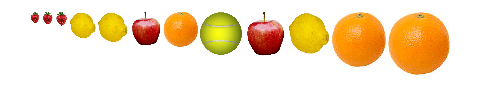

In [233]:
fruits = np.array(['strawberry', 'strawberry', 'strawberry', 'lemon', 'lemon', 'apple', 'orange',
                   'orange', 'apple', 'lemon', 'orange', 'orange'])
sizes  = np.array([.3, .33, .36, .7, .8, .85, .9, 1.1, 1.1, 1.1, 1.4, 1.6])

draw_in_row(fruits, sizes)

In [229]:
['./images/'+fruit+'.png' for fruit in fruits]

['./images/strawberry.png',
 './images/strawberry.png',
 './images/strawberry.png',
 './images/lemon.png',
 './images/lemon.png',
 './images/apple.png',
 './images/orange.png',
 './images/orange.png',
 './images/apple.png',
 './images/lemon.png',
 './images/orange.png',
 './images/orange.png']

## Histogram

By creating a histogram per each foreground fruit (lemons and oranges) and one for the background fruits (strawberries and apples) we can get one type of density estimation with few assumptions about the real distribution.

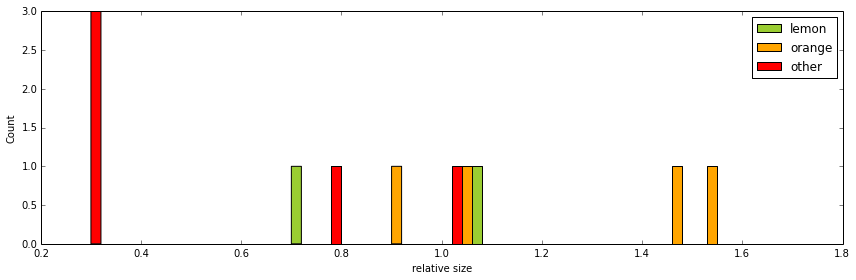

In [230]:
plt.hist(sizes[fruits == 'lemon'], color='yellowgreen', label='lemon', width=0.02)
plt.hist(sizes[fruits == 'orange'], color='orange', label='orange', width=0.02)
plt.hist(sizes[np.logical_not(np.in1d(fruits, ['lemon', 'orange']))], color='red', label='other', width=0.02)
plt.legend()
plt.xlabel('relative size')
plt.ylabel('Count')

## Gaussian

We can instead make the assumption that the sizes of the different fruits are normally distributed following different gaussians. Then, we can try to fit one gaussian per each foreground fruit and one for all the background fruits.

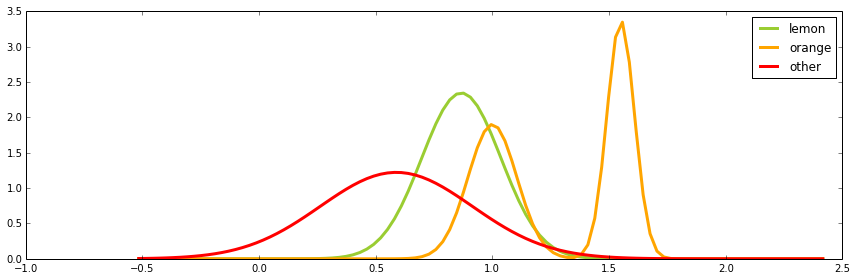

In [213]:
estimator_lemons = MyMultivariateNormal()
estimator_lemons.fit(sizes[fruits == 'lemon'])
estimator_oranges = MyGMM(n_components=2)
estimator_oranges.fit(np.array(sizes[fruits == 'orange']).reshape(-1,1))
estimator_background = MyMultivariateNormal()
estimator_background.fit(sizes[np.logical_and(fruits != 'lemon', fruits != 'orange')])

sizes_linspace = np.linspace(sizes.min()-2*sizes.std(), sizes.max()+2*sizes.std(), 100).reshape(-1,1)

P_R_g_L = estimator_lemons.score(sizes_linspace)
P_R_g_O = estimator_oranges.score(sizes_linspace)
P_R_g_nL_nO = estimator_background.score(sizes_linspace)

plt.plot(sizes_linspace, P_R_g_L, color='yellowgreen', label='lemon', linewidth=3)
plt.plot(sizes_linspace, P_R_g_O, color='orange', label='orange', linewidth=3)
plt.plot(sizes_linspace, P_R_g_nL_nO, color='red', label='other', linewidth=3)
plt.legend()

# Posterior probabilities

What are the posterior probabilities of each fruit given its relative size $R$

$$
    P(L|R) = \frac{P(R|L)*P(L)}{P(R)} = \frac{P(R|L)*P(L)}{P(R|L)*P(L) + P(R|O)*P(O) + P(R|\bar O, \bar L)*P(\bar O,\bar L)}
$$

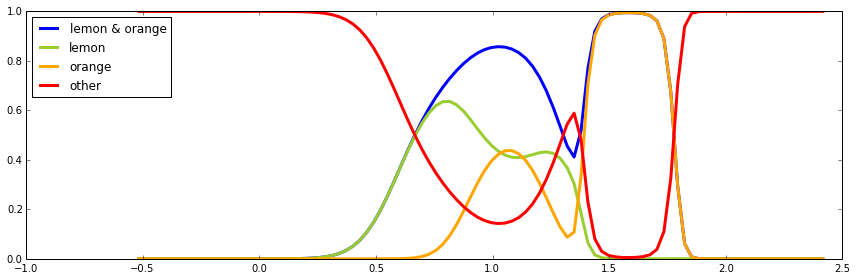

In [214]:
P_L = np.mean(fruits == 'lemon')
P_O = np.mean(fruits == 'orange')
P_nL_nO = P_L = np.mean(np.logical_and(fruits != 'lemon', fruits != 'orange'))

P_R = P_R_g_L*P_L + P_R_g_O*P_O + P_R_g_nL_nO*P_nL_nO

P_L_g_R = P_R_g_L*P_L/P_R
P_O_g_R = P_R_g_O*P_O/P_R
P_nL_nO_g_R = P_R_g_nL_nO*P_nL_nO/P_R

plt.plot(sizes_linspace, P_L_g_R+P_O_g_R, color='blue', label='lemon & orange', linewidth=3)
plt.plot(sizes_linspace, P_L_g_R, color='yellowgreen', label='lemon', linewidth=3)
plt.plot(sizes_linspace, P_O_g_R, color='orange', label='orange', linewidth=3)
plt.plot(sizes_linspace, P_nL_nO_g_R, color='red', label='other', linewidth=3)
plt.legend(loc='upper left')

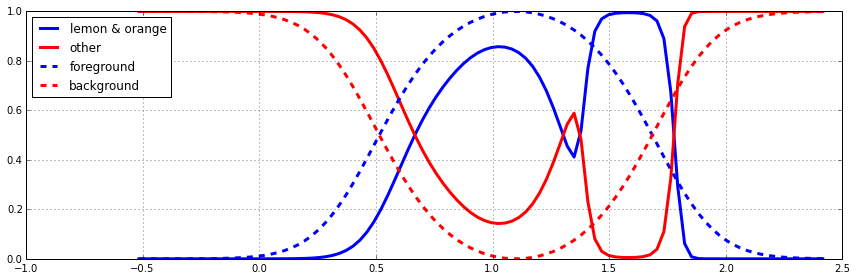

In [215]:
estimator_foreground = BackgroundCheck(mu=0.0, m=1.0)
estimator_foreground.fit(sizes[np.logical_or(fruits == 'lemon', fruits == 'orange')].reshape(-1,1))

posteriors = estimator_foreground.predict_proba(sizes_linspace)

P_F_g_R = posteriors[:,1]
P_B_g_R = posteriors[:,0]

plt.plot(sizes_linspace, P_L_g_R + P_O_g_R, color='blue', label='lemon & orange', linewidth=3)
plt.plot(sizes_linspace, P_nL_nO_g_R, color='red', label='other', linewidth=3)
plt.plot(sizes_linspace, P_F_g_R, '--', color='blue', label='foreground', linewidth=3)
plt.plot(sizes_linspace, P_B_g_R, '--', color='red', label='background', linewidth=3)
plt.legend(loc='upper left')
plt.grid(True)

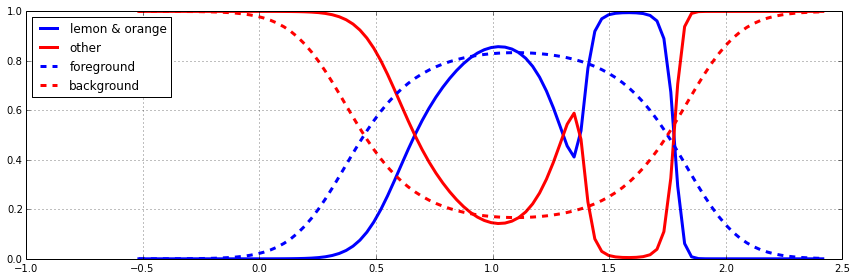

In [216]:
estimator_foreground = BackgroundCheck(mu=0.2, m=0.5)
estimator_foreground.fit(sizes[np.logical_or(fruits == 'lemon', fruits == 'orange')].reshape(-1,1))

plt.plot(sizes_linspace, P_L_g_R + P_O_g_R, color='blue', label='lemon & orange', linewidth=3)
plt.plot(sizes_linspace, P_nL_nO_g_R, color='red', label='other', linewidth=3)
plt.plot(sizes_linspace, estimator_foreground.predict_proba(sizes_linspace)[:,1], '--', color='blue', label='foreground', linewidth=3)
plt.plot(sizes_linspace, estimator_foreground.predict_proba(sizes_linspace)[:,0], '--', color='red', label='background', linewidth=3)
plt.legend(loc='upper left')
plt.grid(True)

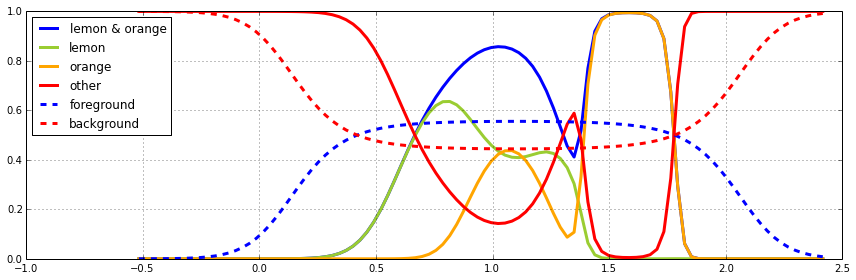

In [217]:
estimator_foreground = BackgroundCheck(mu=0.8, m=0.1)
estimator_foreground.fit(sizes[np.logical_or(fruits == 'lemon', fruits == 'orange')].reshape(-1,1))

plt.plot(sizes_linspace, P_L_g_R + P_O_g_R, color='blue', label='lemon & orange', linewidth=3)
plt.plot(sizes_linspace, P_L_g_R, color='yellowgreen', label='lemon', linewidth=3)
plt.plot(sizes_linspace, P_O_g_R, color='orange', label='orange', linewidth=3)
plt.plot(sizes_linspace, P_nL_nO_g_R, color='red', label='other', linewidth=3)
plt.plot(sizes_linspace, estimator_foreground.predict_proba(sizes_linspace)[:,1], '--', color='blue', label='foreground', linewidth=3)
plt.plot(sizes_linspace, estimator_foreground.predict_proba(sizes_linspace)[:,0], '--', color='red', label='background', linewidth=3)
plt.legend(loc='upper left')
plt.grid(True)

# Posterior probabilities

What are the posterior probabilities of each fruit given its relative size $R$

$$
    P(L|R) = \frac{P(R|L)*P(L)}{P(R)} = \frac{P(R|L)*P(L)}{P(R|L)*P(L) + P(R|O)*P(O) + P(R,B)}
$$

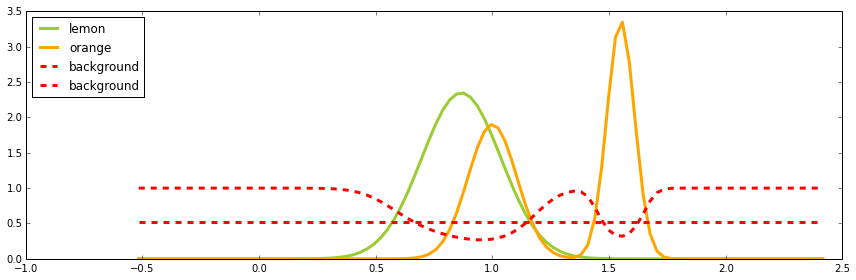

In [218]:
estimator_foreground = BackgroundCheck(mu=1.1, m=0.0)
estimator_foreground.fit(sizes[np.logical_or(fruits == 'lemon', fruits == 'orange')].reshape(-1,1))

Q_R_B = estimator_foreground.predict_proba(sizes_linspace)[:,0]

P_R = P_R_g_L*P_L + P_R_g_O*P_O + Q_R_B

P_L_g_R = P_R_g_L*P_L/P_R
P_O_g_R = P_R_g_O*P_O/P_R
Q_B_g_R = Q_R_B/P_R

plt.plot(sizes_linspace, P_R_g_L, color='yellowgreen', label='lemon', linewidth=3)
plt.plot(sizes_linspace, P_R_g_O, color='orange', label='orange', linewidth=3)
plt.plot(sizes_linspace, Q_B_g_R, '--', color='red', label='background', linewidth=3)
plt.plot(sizes_linspace, Q_R_B, '--', color='red', label='background', linewidth=3)

plt.legend(loc='upper left')

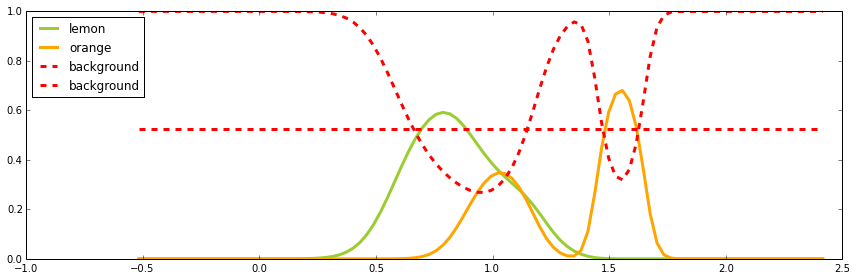

In [219]:
estimator_foreground = BackgroundCheck(mu=1.1, m=0.0)
estimator_foreground.fit(sizes[np.logical_or(fruits == 'lemon', fruits == 'orange')].reshape(-1,1))

Q_R_B = estimator_foreground.predict_proba(sizes_linspace)[:,0]

P_R = P_R_g_L*P_L + P_R_g_O*P_O + Q_R_B

P_L_g_R = P_R_g_L*P_L/P_R
P_O_g_R = P_R_g_O*P_O/P_R
Q_B_g_R = Q_R_B/P_R

plt.plot(sizes_linspace, P_L_g_R, color='yellowgreen', label='lemon', linewidth=3)
plt.plot(sizes_linspace, P_O_g_R, color='orange', label='orange', linewidth=3)
plt.plot(sizes_linspace, Q_B_g_R, '--', color='red', label='background', linewidth=3)
plt.plot(sizes_linspace, Q_R_B, '--', color='red', label='background', linewidth=3)

plt.legend(loc='upper left')

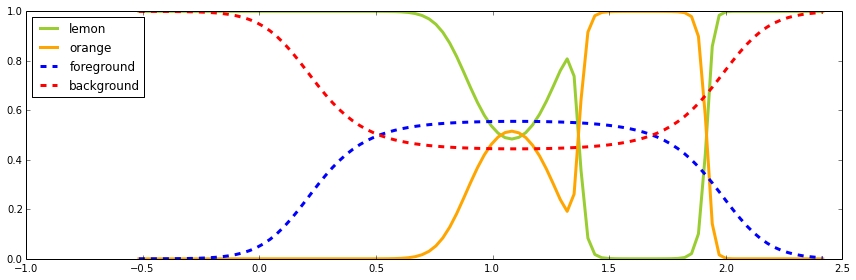

In [220]:
estimator_foreground = BackgroundCheck(mu=.8, m=0.2)
estimator_foreground.fit(sizes[np.logical_or(fruits == 'lemon', fruits == 'orange')].reshape(-1,1))

P_R = P_R_g_L*P_L + P_R_g_O*P_O

P_L_g_R = P_R_g_L*P_L/P_R
P_O_g_R = P_R_g_O*P_O/P_R

plt.plot(sizes_linspace, P_L_g_R, color='yellowgreen', label='lemon', linewidth=3)
plt.plot(sizes_linspace, P_O_g_R, color='orange', label='orange', linewidth=3)
plt.plot(sizes_linspace, estimator_foreground.predict_proba(sizes_linspace)[:,1], '--', color='blue', label='foreground', linewidth=3)
plt.plot(sizes_linspace, estimator_foreground.predict_proba(sizes_linspace)[:,0], '--', color='red', label='background', linewidth=3)
plt.legend(loc='upper left')

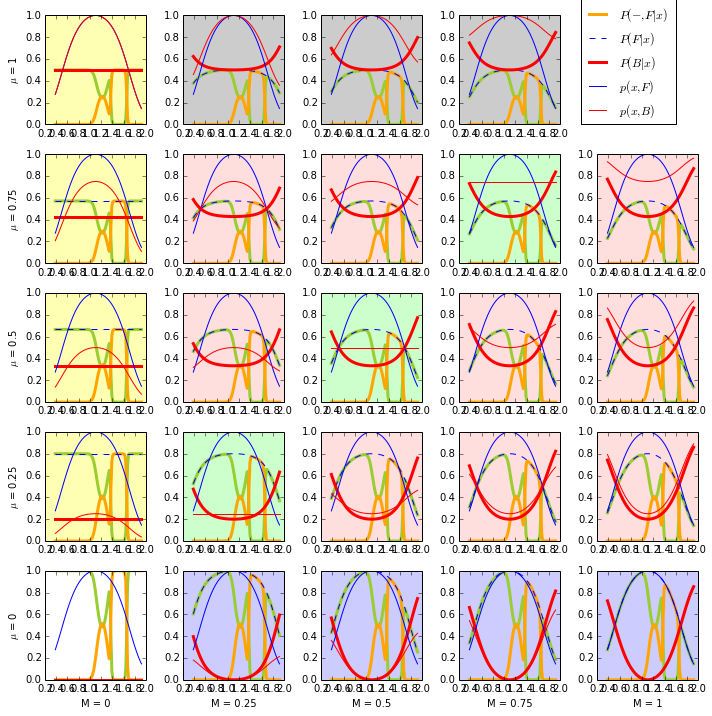

In [221]:
from matplotlib.gridspec import GridSpec
plt.rcParams['figure.autolayout'] = True

x = sizes[np.logical_or(fruits == 'lemon', fruits == 'orange')].reshape(-1,1)
sizes_linspace = np.linspace(x.min()-x.std(), x.max()+x.std(), 100).reshape(-1,1)

values = [0,0.25,0.5,0.75,1]
n_values = len(values)
fig = plt.figure(figsize=(10,10))
plt.subplot(n_values, n_values, 1)
for i, mu in enumerate(reversed(values)):
    for j, m in enumerate(values):
        estimator_foreground = BackgroundCheck(mu=mu, m=m)
        estimator_foreground.fit(x)
        q, p_x_and_b = estimator_foreground.compute_q_p_x_and_b(sizes_linspace)
        
        P_R = P_R_g_L*P_L + P_R_g_O*P_O

        P_L_g_R = P_R_g_L*P_L/P_R
        P_O_g_R = P_R_g_O*P_O/P_R
        
        P_B_g_R = p_x_and_b/(q+p_x_and_b)
        P_F_g_R = q/(q+p_x_and_b)
        
        P_L_F_g_R = P_L_g_R*P_F_g_R
        P_O_F_g_R = P_O_g_R*P_F_g_R
        
        if i == 0 and j == (n_values-1):
            ax = plt.legend(bbox_to_anchor=(1.2, 0), loc='lower left', borderaxespad=0.)
        else:
            ax = plt.subplot(n_values, n_values, i*n_values+j+1)
            ax.plot(sizes_linspace, P_L_F_g_R, color='yellowgreen', label='$P(+,F|x)$', linewidth=3)
            ax.plot(sizes_linspace, P_O_F_g_R, color='orange', label='$P(-,F|x)$', linewidth=3)
            ax.plot(sizes_linspace, P_F_g_R, '--', color='blue', label='$P(F|x)$', linewidth=1)
            ax.plot(sizes_linspace, P_B_g_R, '-', color='red', label='$P(B|x)$', linewidth=3)

            ax.plot(sizes_linspace, q, '-', color='blue', label='$p(x,F)$')
            ax.plot(sizes_linspace, p_x_and_b, '-', color='red', label='$p(x,B)$')
            ax.set_ylim([0,1])
        
        if i == n_values-1:
            ax.set_xlabel('M = {}'.format(m))
            ax.set_axis_bgcolor((.8,.8,1))
            
        if j == 0:
            ax.set_ylabel('$\mu$ = {}'.format(mu))
            ax.set_axis_bgcolor((1,1,.7))
            
        if i == (n_values-1) and j == 0:
            ax.set_axis_bgcolor((1,1,1))
        elif (i != (n_values-1) and j != 0) and not (i == 0 and j == (n_values-1)):
            if (n_values-i-1) == j:
                ax.set_axis_bgcolor((0.8,1,0.8))
            elif i == 0:
                ax.set_axis_bgcolor((.8,.8,.8))
            else:
                ax.set_axis_bgcolor((1,.87,.87))
            
            
plt.savefig('check_your_background_fig_1.svg')